# Bike Sharing Demand Forecast

Data source: https://www.kaggle.com/c/bike-sharing-demand/data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# TODO: check & clean imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error

## 1. Define Business Goal

Forecast bike demand given the data: datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed.

Example in words: Given the forecasted weather conditions, how many bicycles can we expect to be rented out (city-wide) this Saturday at 2pm?

## 2. Get Data

In [3]:
df = pd.read_csv("../data/bike-sharing-demand/train.csv")

In [4]:
# datetime format string doc: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
df.set_index(keys='datetime', drop=False, inplace=True)

In [7]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

**count** is the sum of:
* **casual** - number of non-registered user rentals initiated
* **registered** - number of registered user rentals initiated

It belongs to our y data (target data), so we can omit it for now.

In [8]:
df.drop(['casual', 'registered'], axis=1, inplace=True)

### Preparation for later feature engineering

In [9]:
# hour
df['hour'] = df['datetime'].dt.hour
# dayofweek
df['dayofweek'] = df['datetime'].dt.dayofweek

In [10]:
# timestamp
timedelta = df.datetime - pd.to_datetime("2010/01/01")
DAY_IN_SECONDS = 60*60*24
df['timestamp'] = timedelta.dt.total_seconds()/(DAY_IN_SECONDS)

In [11]:
df.head(30)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,dayofweek,timestamp
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,5,365.000000
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,5,365.041667
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,5,365.083333
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,5,365.125000
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,5,365.166667
2011-01-01 05:00:00,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1,5,5,365.208333
2011-01-01 06:00:00,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,6,5,365.250000
2011-01-01 07:00:00,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,3,7,5,365.291667
2011-01-01 08:00:00,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,8,8,5,365.333333


## 3. Train-Test-Split

Define X and y:

* X : Training data
* y : Target values

In [12]:
df_full = pd.DataFrame(df) # keep a deep copy of unsplit data

In [13]:
y = df['count']
X = df.drop(['count'], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 4. Explore the Data

* **???** Explore on the *df* or the split data (problem of keeping track of y)
* **???** Explore time series *after* splitting? It will introduce random holes in equal sampled data.

In [15]:
# merge for exploration
df_train = X_train.join(other=y_train)
#df = df_train

In [16]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,dayofweek,timestamp
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,5,365.000000
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,5,365.041667
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,5,365.083333
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,5,365.125000
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,5,365.166667


<AxesSubplot:xlabel='datetime'>

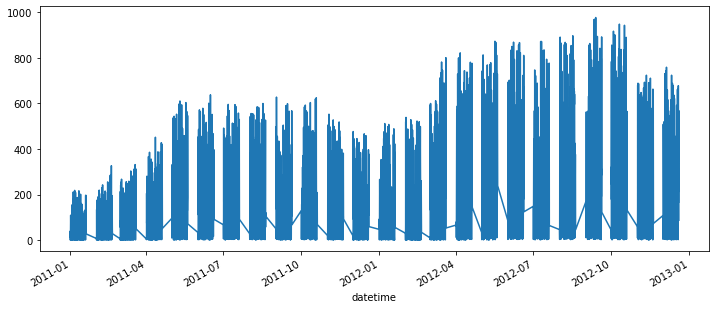

In [17]:
df['count'].plot(figsize=(12,5))

The demand contains a positive trend over the years. Possible strategies may be applied:

* https://machinelearningmastery.com/time-series-trends-in-python/
* https://www.investopedia.com/terms/d/detrend.asp

<AxesSubplot:xlabel='datetime'>

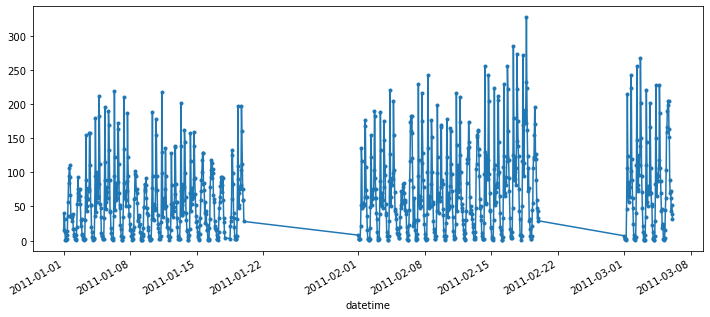

In [18]:
df.iloc[:1000]['count'].plot(figsize=(12,5), style='.-')

### Mind the data gaps

*\"For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.\"*

### Include more data related to time and weather and moving average

<AxesSubplot:xlabel='datetime', ylabel='count'>

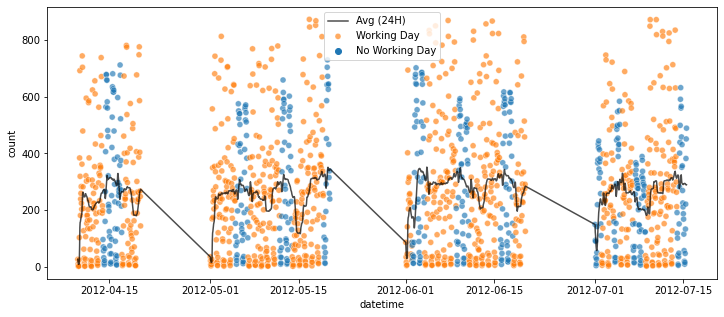

In [19]:
subdf = df.iloc[7000:8500]
window = '24H'

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(ax=ax, data=subdf.rolling(window).mean(), x=df.index.name, y='count', color='k', legend='brief', alpha=0.7)
sns.scatterplot(ax=ax, data=subdf, x=df.index.name, y='count', hue='workingday', alpha=0.65)
ax.legend(['Avg ({})'.format(window), 'Working Day', 'No Working Day'])
ax

Comparing work to non-work days you can see all scenarios:
* more than local avg demand
* same ...
* less ...

<AxesSubplot:xlabel='datetime', ylabel='count'>

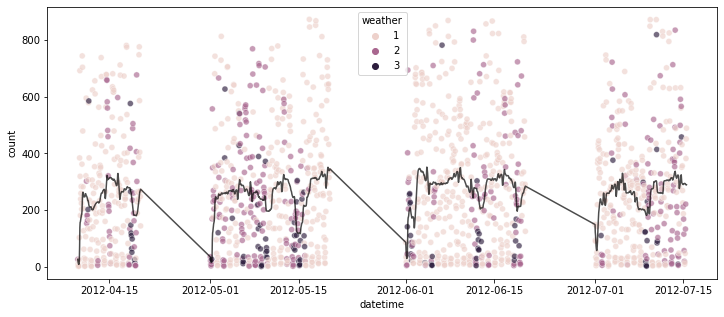

In [20]:
subdf = df.iloc[7000:8500]
window = '24H'

fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(ax=ax, data=subdf.rolling(window).mean(), x=df.index.name, y='count', color='k', legend='brief', alpha=0.7)
sns.scatterplot(ax=ax, data=subdf, x=df.index.name, y='count', hue='weather', alpha=0.65)
ax

Demand dips on days with bad weather.

Accessing DataFrames by datetime: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

### Weather Type 4 almost not present in data

* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

<AxesSubplot:ylabel='Frequency'>

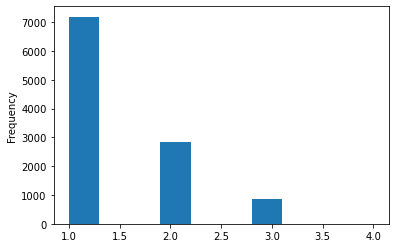

In [21]:
df['weather'].plot.hist()

In [22]:
df.loc[df['weather'] > 3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,dayofweek,timestamp
datetime,,,,,,,,,,,,,
2012-01-09 18:00:00,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,164,18,0,738.75


### Explore correlations

In [23]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,dayofweek,timestamp
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,5,365.000000
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,5,365.041667
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,5,365.083333
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,5,365.125000
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,5,365.166667


<AxesSubplot:xlabel='temp', ylabel='count'>

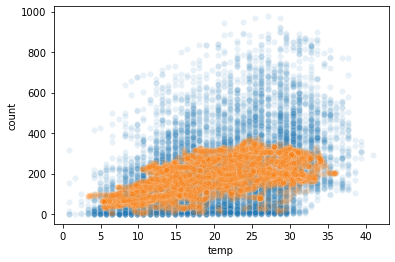

In [24]:
subdf = df.rolling('24H').mean()
ax = sns.scatterplot(       data=df   , y='count', x='temp', alpha=0.1)
ax = sns.scatterplot(ax=ax, data=subdf, y='count', x='temp', alpha=0.1)
ax

<AxesSubplot:xlabel='atemp', ylabel='count'>

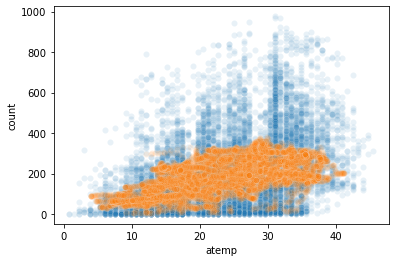

In [25]:
feat = 'atemp'
subdf = df.rolling('24H').mean()
ax = sns.scatterplot(       data=df   , y='count', x=feat, alpha=0.1)
ax = sns.scatterplot(ax=ax, data=subdf, y='count', x=feat, alpha=0.1)
ax

Higher temps -> higher demand

<AxesSubplot:xlabel='humidity', ylabel='count'>

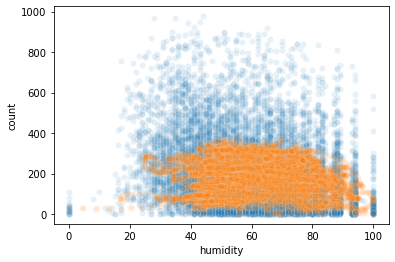

In [26]:
feat = 'humidity'
subdf = df.rolling('24H').mean()
ax = sns.scatterplot(       data=df   , y='count', x=feat, alpha=0.1)
ax = sns.scatterplot(ax=ax, data=subdf, y='count', x=feat, alpha=0.1)
ax

Humidity above 80 goes with a decrease in demand.

<AxesSubplot:xlabel='windspeed', ylabel='count'>

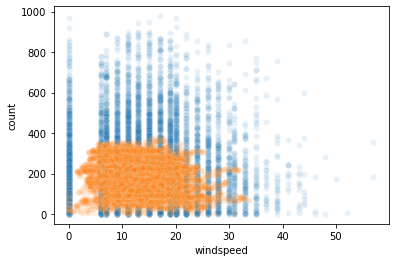

In [27]:
feat = 'windspeed'
subdf = df.rolling('24H').mean()
ax = sns.scatterplot(       data=df   , y='count', x=feat, alpha=0.1)
ax = sns.scatterplot(ax=ax, data=subdf, y='count', x=feat, alpha=0.1)
ax

High windspeeds go with decrease in demand.

### Ideas

* Bin humidity/temps and calculate mean deamand for each range. (With help of sklearn preprocessors)
* temp vs atemp correlation: does it actually contain additional information?
* use season, hoiday, workday, wheathertype
* use resample method (props to catarina)
* use conditional probability/thinking: e.g. if wheather = 1 ==> stronger correlation between temp and demand

In [28]:
# binning by temperature and plot mean demand
df['temp_b'] = pd.cut(x=df['temp'], bins=int((df['temp'].max()-df['temp'].min())/1.5))

<AxesSubplot:xlabel='temp_b'>

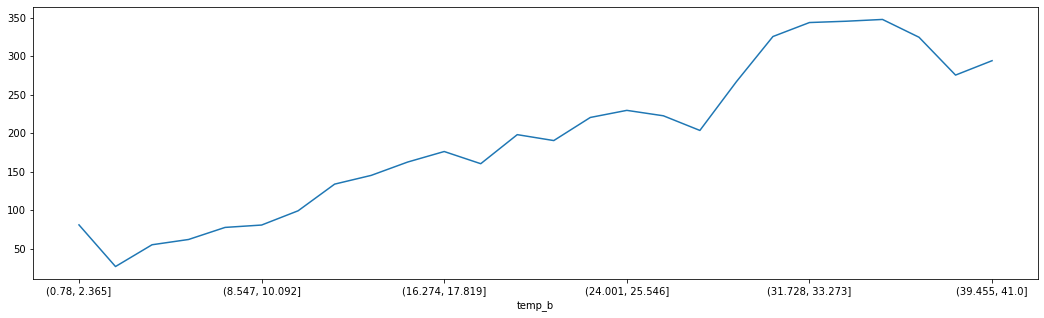

In [29]:
subdf=df[['temp_b','count']].groupby('temp_b').mean()
subdf['count'].plot(figsize=(18,5))

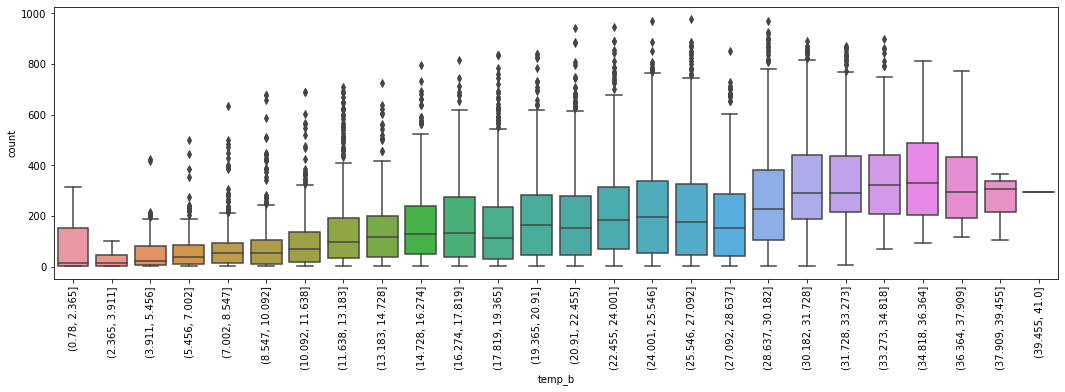

In [30]:
fig, ax = plt.subplots(figsize=(18,5))
# thanks to alisa
sns.boxplot(ax=ax, data=df[['temp_b','count']], x='temp_b', y='count')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
pass

<AxesSubplot:xlabel='windspeed_b'>

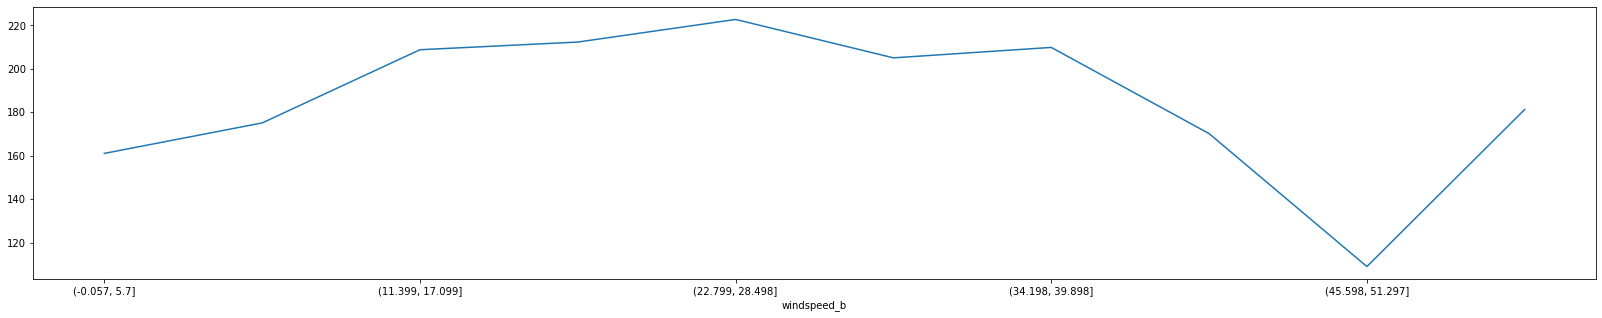

In [31]:
# binning by windspeed and plot mean demand
df['windspeed_b'] = pd.cut(x=df['windspeed'], bins=10)
subdf = df[['windspeed_b','count']].groupby('windspeed_b').mean()
subdf['count'].plot(figsize=(28,5))

## 5. Feature engineering

### Add time related features

* Day number since unix epoch (for implicit detrend of demand)
* Week day, hour, day of month  (one-hot-encoded and/or ordinal)

### Additional features

* Interaction terms, Polynomial terms

### Helpful material
* datetime docs: https://docs.python.org/3/library/datetime.html#datetime.datetime.timestamp
* datetime in pandas: https://towardsdatascience.com/working-with-datetime-in-pandas-dataframe-663f7af6c587

In [32]:
X_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,dayofweek,timestamp
datetime,,,,,,,,,,,,
2011-07-11 00:00:00,2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980,0,0,556.000000
2012-05-18 22:00:00,2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028,22,4,868.916667
2011-04-01 23:00:00,2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032,23,4,455.958333
2012-09-16 09:00:00,2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981,9,6,989.375000
2011-02-01 23:00:00,2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980,23,1,396.958333


### Considerations

* Hour, dayofweek -> numeric or one-hot-encoded ?
* Wheather -> num and/or one-hot ?

In [207]:
column_transformer = make_column_transformer(
     [ StandardScaler() , ['timestamp', 'hour', 'dayofweek'] ]
    ,[ StandardScaler() , ['weather'] ]
    ,[ StandardScaler() , ['windspeed', 'humidity', 'temp', 'atemp'] ]
    ,[ OneHotEncoder(sparse=False) , ['workingday', 'holiday'] ]
    ,[ OneHotEncoder(sparse=False) , ['season'] ]
    # playground
    ,[ OneHotEncoder(sparse=False) , ['hour', 'dayofweek'] ]
)

transformer = make_pipeline( column_transformer
                            ,PolynomialFeatures(degree=2) )
#transformer = column_transformer

transformer

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler-1',
                                                  StandardScaler(),
                                                  ['timestamp', 'hour',
                                                   'dayofweek']),
                                                 ('standardscaler-2',
                                                  StandardScaler(),
                                                  ['weather']),
                                                 ('standardscaler-3',
                                                  StandardScaler(),
                                                  ['windspeed', 'humidity',
                                                   'temp', 'atemp']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(sparse=False),
                                                  ['

In [208]:
transformer.fit(X_train)
X_train_tf = transformer.transform(X_train)
X_test_tf  = transformer.transform(X_test)
X_train_tf.shape, X_test_tf.shape

((8164, 1176), (2722, 1176))

In [284]:
m = Lasso(alpha=0.4)

In [285]:
_tol = 0.01
m.fit(X_train_tf, y_train)
(m.coef_ < _tol).sum(), m.coef_

(1092,
 array([ 0.00000000e+00,  3.55006963e+01,  6.30873038e+01, ...,
         2.07846834e-02,  0.00000000e+00, -0.00000000e+00]))

In [286]:
for i in (m.coef_ > _tol):
    print("#" if i else "_",end=' ')

_ # # _ _ _ _ # _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # # # _ _ _ _ _ _ _ _ _ _ _ _ # # _ _ # _ _ # _ # # _ # _ _ _ _ _ _ _ _ _ _ # # # _ _ # _ _ _ # # # _ _ _ _ _ _ _ # # _ # _ _ _ _ _ _ # # _ # _ _ _ # _ _ _ _ _ # # _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ # _ _ # _ _ _ _ _ _ _ _ _ # # # # # # # _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # # # _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # _ # _ _ _ # _ _ _ _ _ _ _ _ _ _ _ _ # # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # # _ # _ _ _ _ _ _ _ _ _ _ _ # # _ _ _ _ # _ # _ _ _ _ _ _ _ # _ _ _ _ # _ _ _ _ # # _ _ _ _ _ _ _ _ _ _ _ _ # _ _ _ _ _ _ # _ _ _ _ _ _ _ _ _ _ _ # # # # # # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ # # # _ _ _ _ _ _ _ # # # _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

In [287]:
y_pred_test = m.predict(X_test_tf)

In [288]:
y_pred_test

array([143.07911258, -12.49192334,  99.22876563, ...,  30.05073686,
       116.31845763, 223.70593059])

In [289]:
m.score(X_train_tf, y_train)

0.9009782770628979

In [290]:
mean_squared_error(y_train, m.predict(X_train_tf))

3248.7870599438174

In [291]:
mean_squared_error(y_test, m.predict(X_test_tf))

3486.8481756081283

In [292]:
scores = cross_val_score(m, X_train_tf, y_train, cv=5, scoring='neg_mean_squared_error')

In [293]:
scores.mean(), scores

(-3461.9814684062667,
 array([-3905.1432128 , -3135.2537758 , -3500.14760642, -3625.54984423,
        -3143.81290278]))

Note the reason for negative mse (neg_mean_squared_error) is that higher value should be better: https://stackoverflow.com/a/48246255

## 6. Train Models